# **1. Import Library**

In [47]:
import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import pandas as pd
from pprint import pprint

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, classification_report
import matplotlib.pyplot as plt

# Optional advanced models
try:
    from xgboost import XGBClassifier
    _HAS_XGB = True
except Exception:
    _HAS_XGB = False

try:
    from lightgbm import LGBMClassifier
    _HAS_LGBM = True
except Exception:
    _HAS_LGBM = False

try:
    import shap
    _HAS_SHAP = True
except Exception:
    _HAS_SHAP = False

try:
    from imblearn.over_sampling import SMOTE
    from imblearn.pipeline import Pipeline as ImbPipeline
    _HAS_SMOTE = True
except Exception:
    _HAS_SMOTE = False

# Settings
RANDOM_STATE = 42
USE_SMOTE = True  # AKTIFKAN SMOTE
N_JOBS = -1
N_ITER_SEARCH = 40

# **2. Load Dataset**

In [48]:
# Load data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
print(f"Train shape: {train.shape}, Test shape: {test.shape}")

Train shape: (1176, 36), Test shape: (294, 35)


# **3. Encoding**

In [49]:
# Target encoding
TARGET = 'Attrition'
if train[TARGET].dtype == 'object':
    train[TARGET] = train[TARGET].map(lambda x: 1 if str(x).strip().lower() in ['yes', '1', 'y', 'true'] else 0)

X = train.drop(columns=[TARGET])
y = train[TARGET]

# **4. Identifikasi Var Numerik dan Kategorik**

In [50]:
# Hapus kolom yang tidak relevan
drop_cols = ["EmployeeCount", "Over18", "StandardHours", "EmployeeNumber"]
drop_cols = [col for col in drop_cols if col in X.columns]

X = X.drop(columns=drop_cols)


In [51]:
# Kolom kategorik encoded numerik
encoded_cat_cols = [
    "Education",
    "EnvironmentSatisfaction",
    "JobInvolvement",
    "JobLevel",
    "JobSatisfaction",
    "PerformanceRating",
    "RelationshipSatisfaction",
    "StockOptionLevel",
    "WorkLifeBalance"
]

# Kolom kategorik bertipe object/bool
obj_cat_cols = X.select_dtypes(include=["object", "bool"]).columns.tolist()

# Gabungan semua kategorik
cat_cols = list(set(obj_cat_cols + encoded_cat_cols))

# Numeric yang benar-benar numerik (selain target)
num_cols = [
    col for col in X.select_dtypes(include=["int64", "float64"]).columns
    if col not in encoded_cat_cols and col != "Attrition"
]

In [52]:
print("Final Feature Groups:")
print(f"Numeric features  : {len(num_cols)} → {num_cols}")
print(f"Categoric features: {len(cat_cols)} → {cat_cols}")
print(f"Dropped columns   : {drop_cols}")

Final Feature Groups:
Numeric features  : 14 → ['Age', 'DailyRate', 'DistanceFromHome', 'HourlyRate', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike', 'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']
Categoric features: 17 → ['id', 'EnvironmentSatisfaction', 'WorkLifeBalance', 'EducationField', 'MaritalStatus', 'OverTime', 'Education', 'JobInvolvement', 'BusinessTravel', 'JobLevel', 'JobRole', 'PerformanceRating', 'Department', 'RelationshipSatisfaction', 'StockOptionLevel', 'Gender', 'JobSatisfaction']
Dropped columns   : ['EmployeeCount', 'Over18', 'StandardHours', 'EmployeeNumber']


# **5. EDA dan Visualisasi** #

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [54]:
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (8, 5)

In [55]:
df_eda = train.copy()

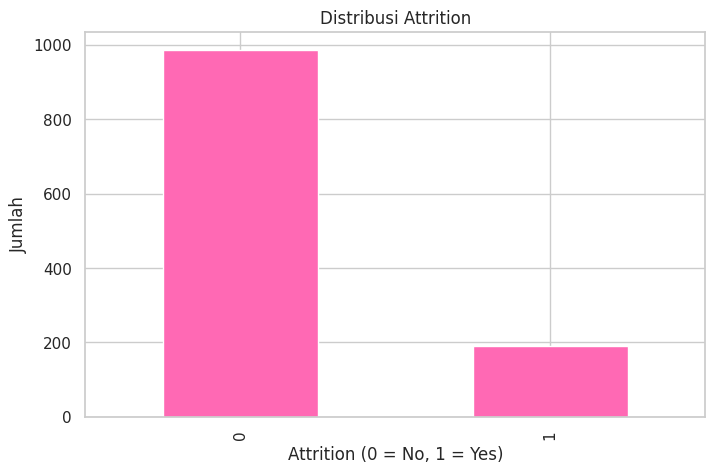

In [56]:
# Distribusi Attrition
df_eda["Attrition"].value_counts().plot(kind="bar", color='hotpink')
plt.title("Distribusi Attrition")
plt.xlabel("Attrition (0 = No, 1 = Yes)")
plt.ylabel("Jumlah")
plt.show()

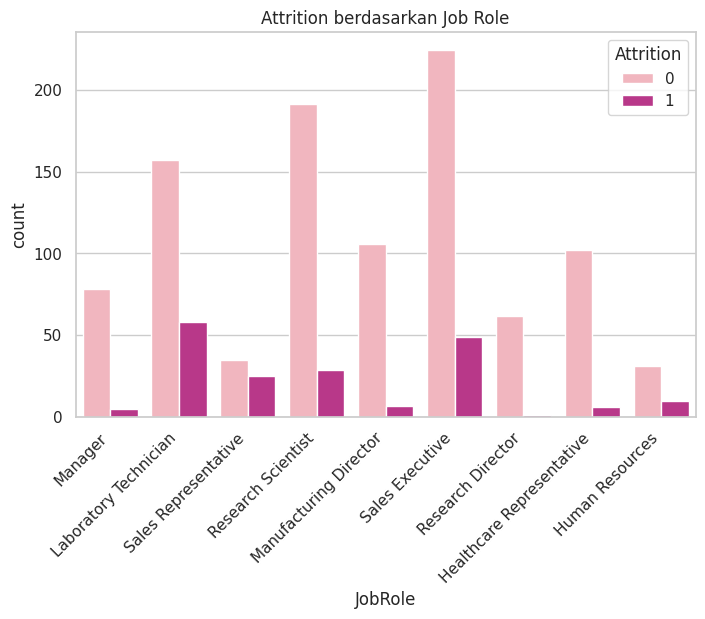

In [57]:
# Attrition berdasarkan JobRole
sns.countplot(data=df_eda, x="JobRole", hue="Attrition", palette='RdPu')
plt.title("Attrition berdasarkan Job Role")
plt.xticks(rotation=45, ha="right")
plt.show()

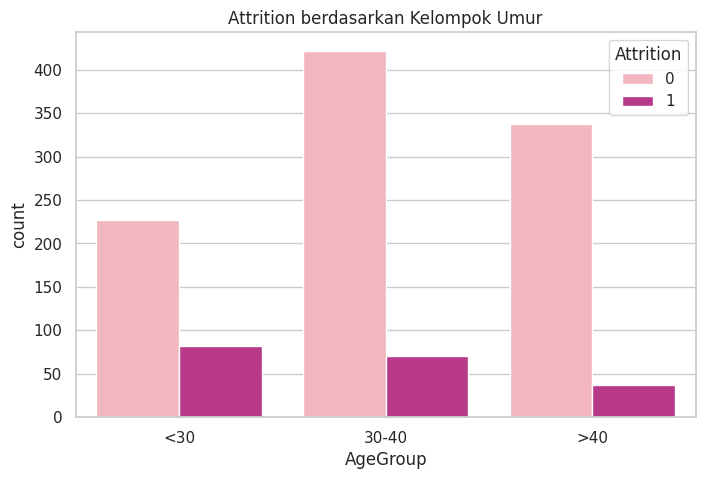

In [58]:
# Attrition berdasarkan Age Group
df_eda["AgeGroup"] = pd.cut(df_eda["Age"], bins=[17, 30, 40, 60], labels=["<30", "30-40", ">40"])
sns.countplot(data=df_eda, x="AgeGroup", hue="Attrition", palette='RdPu')
plt.title("Attrition berdasarkan Kelompok Umur")
plt.show()

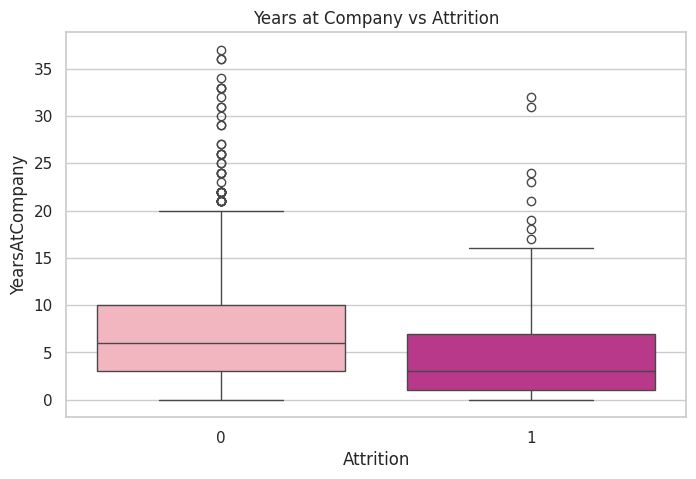

In [59]:
# Attrition berdasarkan Lama Bekerja
sns.boxplot(data=df_eda, x="Attrition", y="YearsAtCompany", palette='RdPu')
plt.title("Years at Company vs Attrition")
plt.show()

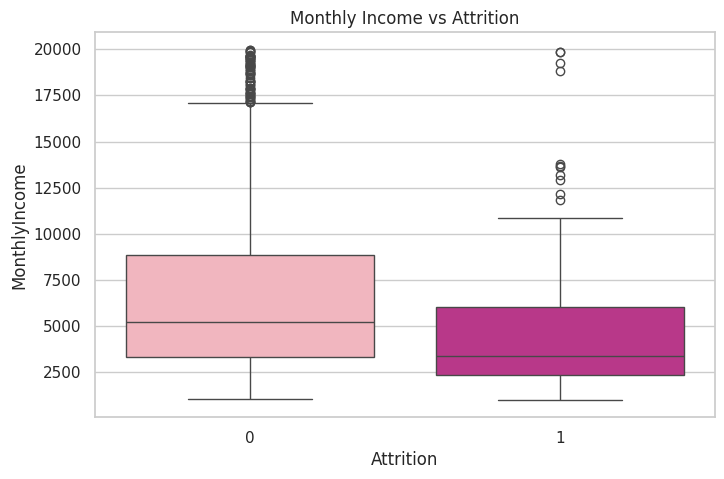

In [60]:
# Attrition berdasarkan Monthly Income
sns.boxplot(data=df_eda, x="Attrition", y="MonthlyIncome", palette='RdPu')
plt.title("Monthly Income vs Attrition")
plt.show()

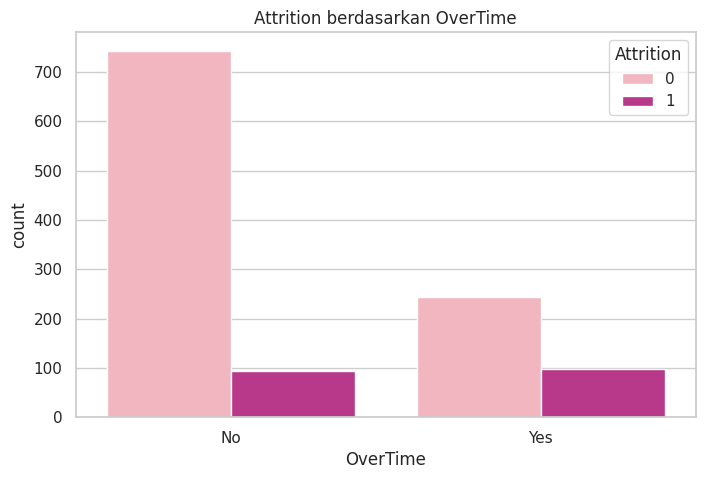

In [61]:
# OverTime sebagai faktor Attrition
sns.countplot(data=df_eda, x="OverTime", hue="Attrition", palette='RdPu')
plt.title("Attrition berdasarkan OverTime")
plt.show()

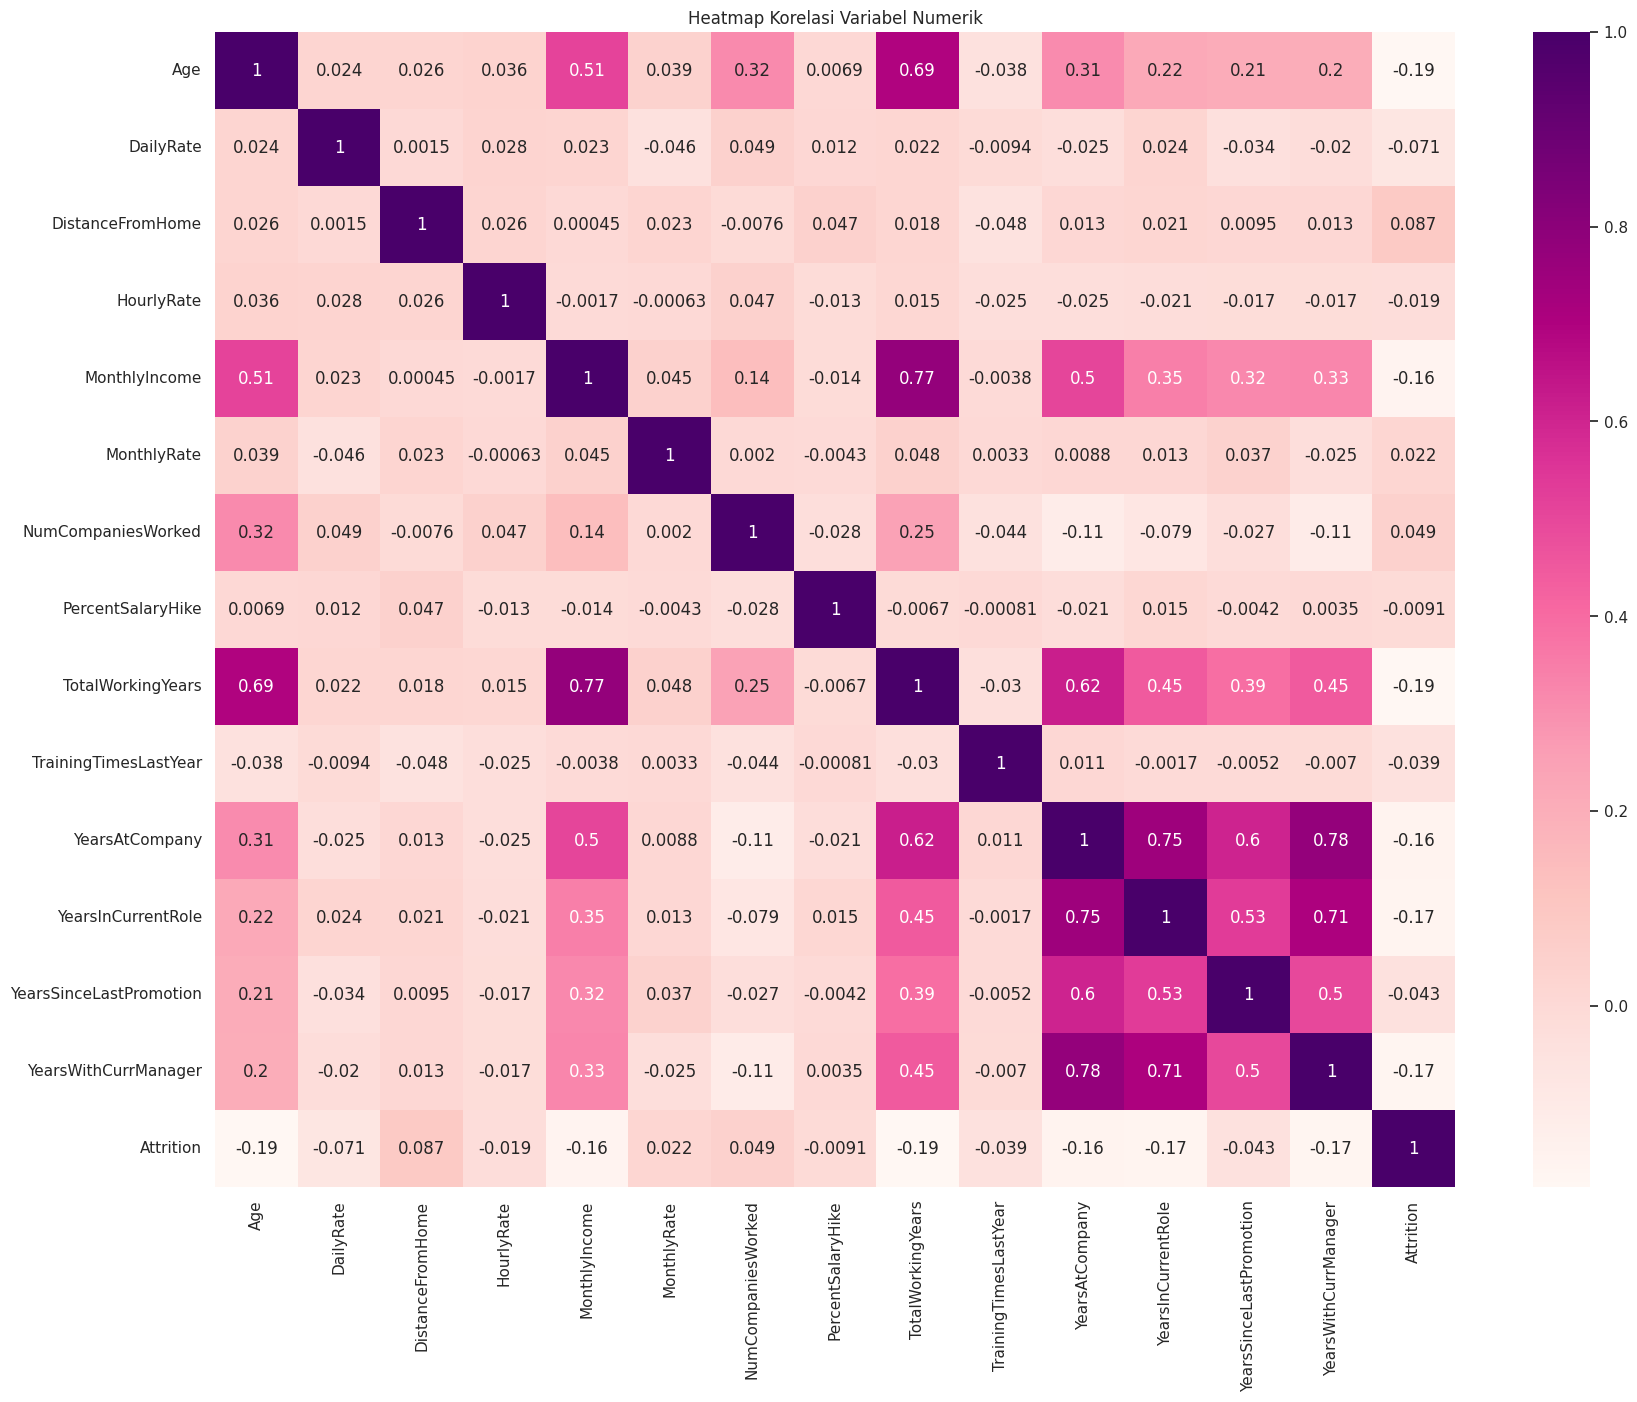

Top Korelasi with Attrition:
Attrition                  1.000000
DistanceFromHome           0.086744
NumCompaniesWorked         0.048648
MonthlyRate                0.021787
PercentSalaryHike         -0.009148
HourlyRate                -0.019400
TrainingTimesLastYear     -0.039445
YearsSinceLastPromotion   -0.042942
DailyRate                 -0.071398
YearsAtCompany            -0.155139
Name: Attrition, dtype: float64


In [62]:
# Korelasi dengan variabel numerik
corr = df_eda[num_cols + ['Attrition']].corr()["Attrition"].sort_values(ascending=False)

plt.figure(figsize=(20, 15))
sns.heatmap(df_eda[num_cols + ['Attrition']].corr(), annot=True, cmap="RdPu")
plt.title("Heatmap Korelasi Variabel Numerik")
plt.show()

print("Top Korelasi with Attrition:")
print(corr.head(10))

# **5. Split Dataset**

In [63]:
# Split
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=RANDOM_STATE)

# **6. Preprocessing**

In [64]:
# Check missing value di df_train dan df_test
display(train.isnull().sum())
display(test.isnull().sum())

,0
id,0
Age,0
BusinessTravel,0
DailyRate,0
Department,0
DistanceFromHome,0
Education,0
EducationField,0
EmployeeCount,0
EmployeeNumber,0


,0
id,0
Age,0
BusinessTravel,0
DailyRate,0
Department,0
DistanceFromHome,0
Education,0
EducationField,0
EmployeeCount,0
EmployeeNumber,0


In [65]:
# Check duplikasi df_train dan df_test
display(train.duplicated().sum())
display(test.duplicated().sum())


np.int64(0)

np.int64(0)

In [66]:
# Preprocessing
num_trans = Pipeline([('imp', SimpleImputer(strategy='median')),
                      ('sc', StandardScaler())])
cat_trans = Pipeline([('imp', SimpleImputer(strategy='most_frequent')),
                      ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])
preproc = ColumnTransformer([('num', num_trans, num_cols),
                             ('cat', cat_trans, cat_cols)])

def build_pipeline(model):
    if USE_SMOTE and _HAS_SMOTE:
        return ImbPipeline([
            ('preproc', preproc),
            ('smote', SMOTE(random_state=RANDOM_STATE)),
            ('clf', model)
        ])
    else:
        return Pipeline([
            ('preproc', preproc),
            ('clf', model)
        ])


# **7. Best Model**

In [67]:
# Models + Search Space
models = {}

# Logistic Regression
lr = LogisticRegression(max_iter=2000, solver='liblinear', class_weight='balanced', random_state=RANDOM_STATE)
models['logistic'] = {
    'pipeline': build_pipeline(lr),
    'param_dist': {
        'clf__C': np.logspace(-3, 2, 10),
        'clf__penalty': ['l1', 'l2']
    }
}

# Random Forest
rf = RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced')
models['random_forest'] = {
    'pipeline': build_pipeline(rf),
    'param_dist': {
        'clf__n_estimators': [200, 400, 600],
        'clf__max_depth': [8, 12, 20, None],
        'clf__min_samples_split': [2, 5, 10],
        'clf__min_samples_leaf': [1, 2, 4]
    }
}

# XGBoost
if _HAS_XGB:
    xgb = XGBClassifier(use_label_encoder=False, eval_metric='auc', random_state=RANDOM_STATE)
    models['xgboost'] = {
        'pipeline': build_pipeline(xgb),
        'param_dist': {
            'clf__n_estimators': [200, 400],
            'clf__max_depth': [3, 5, 8],
            'clf__learning_rate': [0.01, 0.05, 0.1],
            'clf__subsample': [0.7, 0.9, 1.0],
            'clf__colsample_bytree': [0.6, 0.8, 1.0]
        }
    }

# LightGBM
if _HAS_LGBM:
    lgbm = LGBMClassifier(random_state=RANDOM_STATE, class_weight='balanced')
    models['lightgbm'] = {
        'pipeline': build_pipeline(lgbm),
        'param_dist': {
            'clf__n_estimators': [300, 500],
            'clf__max_depth': [-1, 8, 12],
            'clf__learning_rate': [0.01, 0.05, 0.1],
            'clf__num_leaves': [15, 31, 63],
            'clf__subsample': [0.7, 0.9, 1.0]
        }
    }


# **8. Training**

In [68]:
# Training
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
results = []

for name, spec in models.items():
    print(f"\n=== Training {name} ===")
    search = RandomizedSearchCV(
        estimator=spec['pipeline'],
        param_distributions=spec['param_dist'],
        n_iter=min(N_ITER_SEARCH, len(spec['param_dist'])*6),
        scoring='roc_auc',
        n_jobs=N_JOBS,
        cv=skf,
        verbose=1,
        random_state=RANDOM_STATE
    )
    search.fit(X_train, y_train)
    y_pred_proba = search.best_estimator_.predict_proba(X_val)[:,1]
    val_auc = roc_auc_score(y_val, y_pred_proba)
    results.append((name, val_auc, search.best_estimator_))
    print(f"Best CV AUC: {search.best_score_:.4f} | Val AUC: {val_auc:.4f}")
    print(f"Best params: {search.best_params_}")


=== Training logistic ===
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best CV AUC: 0.8445 | Val AUC: 0.8400
Best params: {'clf__penalty': 'l1', 'clf__C': np.float64(27.825594022071257)}

=== Training random_forest ===
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best CV AUC: 0.8062 | Val AUC: 0.8408
Best params: {'clf__n_estimators': 200, 'clf__min_samples_split': 2, 'clf__min_samples_leaf': 2, 'clf__max_depth': 12}

=== Training xgboost ===
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best CV AUC: 0.8335 | Val AUC: 0.8024
Best params: {'clf__subsample': 0.7, 'clf__n_estimators': 400, 'clf__max_depth': 3, 'clf__learning_rate': 0.05, 'clf__colsample_bytree': 0.8}

=== Training lightgbm ===
Fitting 5 folds for each of 30 candidates, totalling 150 fits
[LightGBM] [Info] Number of positive: 788, number of negative: 788
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002198 seconds.
You can set `forc

# **9. Evaluasi**


Best model: random_forest | Validation ROC-AUC = 0.8408


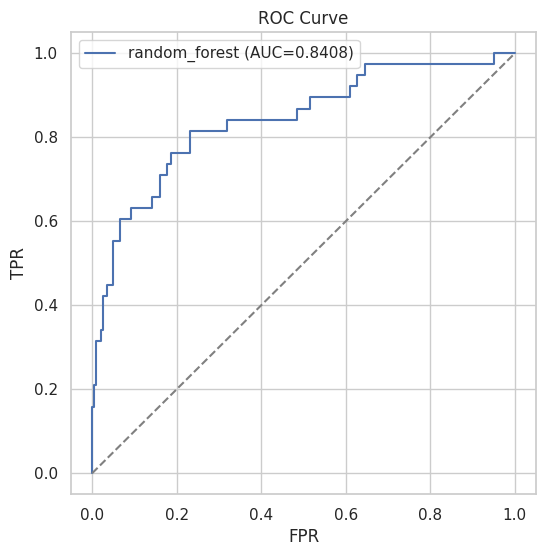

In [69]:
# Evaluation
results = sorted(results, key=lambda x: x[1], reverse=True)
best_name, best_auc, best_model = results[0]
print(f"\nBest model: {best_name} | Validation ROC-AUC = {best_auc:.4f}")

fpr, tpr, _ = roc_curve(y_val, best_model.predict_proba(X_val)[:,1])
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'{best_name} (AUC={best_auc:.4f})')
plt.plot([0,1],[0,1],'--',color='gray')
plt.legend(); plt.title("ROC Curve"); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.grid(True); plt.show()


# **10. Download File Submission**

In [72]:
#Download file susmission
if test is not None:
    print("\n=== Generating submission ===")
    preds = best_model.predict_proba(test)[:,1]

    # If original had an id column we removed, try to infer file id
    idcol = None
    for c in ['id', 'EmployeeNumber', 'employee_id', 'EmployeeID']:
        if c in pd.read_csv('train.csv').columns:
            idcol = c
            break

    submission = pd.DataFrame({'prediction': preds})
    if idcol is not None and idcol in pd.read_csv('test.csv').columns:
        submission[idcol] = pd.read_csv('test.csv')[idcol]
        submission = submission[[idcol, 'prediction']]
    out_path = 'submission_16.csv'
    submission.to_csv(out_path, index=False)
    print(f'Saved predictions to {out_path}')



=== Generating submission ===
Saved predictions to submission_16.csv


In [73]:
# Save final model
import joblib
joblib.dump(best_model, 'final_model.pkl')
print('Model saved')

Model saved
